# Fraud Detection Sample Project 
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent 
- Outline Structure 
    - Pre-processing data (merging two datasets to get customer's country information, missing value etc)
    - Exploratory Data Analysis 
    - Feature Engineering 
    - Building Machine Learning Models Using Undersampling and Oversampling techniques
    - Optimization ML Model (GridSearchCV, RandomizedSearchCV)
    - Evaluation 
    - Building Deep Learning Model Using Undersampling and Oversampling techniques 
    - Evaluation
    - Conclusion and Recommendation 

In [1]:
# Import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Pre-processing feature libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# ML model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm

# ANN model libraries
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Optimizing and Evaluation libraries 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,average_precision_score
from collections import Counter
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

## Pre-processing data

In [2]:
# Loading the 2 available files data 
# Remove the first unnamed column which might indicate the old index of the data 
# Defined the datatype for each features such as time as date type, user_id as strings
fraud_df = pd.read_csv("CoE Full Time/Candidate_tech_evaluation_candidate_copy_data science_fraud.csv", parse_dates= ['signup_time','purchase_time'],
                      dtype = {'user_id':'str'}).iloc[:, 1:]

ip_country = pd.read_excel("CoE Full Time/Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx")

In [3]:
# Merge two datasets to get the customer's country information

# Add a new column to fraud_df, which will contain an index of the first matching IP interval from the ip_country
fraud_df['index_x'] = (fraud_df['ip_address'].apply(lambda x: ip_country.query('lower_bound_ip_address <= @x <= upper_bound_ip_address').index.values).apply(lambda x: x[0] if len(x) else -1))

# Merge both datasets
fraud_df = pd.merge(fraud_df, ip_country.filter(regex=r'^((?!.?ip_address_).*)$'), left_on='index_x', right_index=True, how='left').drop('index_x',1)

In [4]:
fraud_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2.818376e+09,2.818408e+09,United States
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,3.251268e+09,3.251268e+09,United Kingdom
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,2.727608e+09,2.727870e+09,United States
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,2.083389e+09,2.083422e+09,Korea Republic of
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,3.207909e+09,3.207913e+09,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,116698,2015-02-26 11:51:00,2015-04-16 22:57:00,46,UJYRDGZXTFFJG,Ads,Chrome,M,18,2.509395e+09,0,2.509373e+09,2.509439e+09,Netherlands
119996,122699,2015-08-01 18:40:00,2015-08-25 07:56:00,26,EMMTCPTUYQYPX,Ads,IE,F,36,2.946612e+09,0,2.946499e+09,2.947547e+09,China
119997,115120,2015-07-25 12:50:00,2015-09-03 04:10:00,41,YSZGGEARGETEU,SEO,Chrome,M,31,5.570629e+08,0,5.536481e+08,5.704253e+08,United States
119998,87098,2015-04-02 21:11:00,2015-06-22 16:51:00,50,BJDWRJULJZNOV,SEO,Chrome,F,43,2.687887e+09,0,2.687828e+09,2.687894e+09,Switzerland


In [5]:
fraud_df.describe() 

,purchase_value,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address
count,120000.000000,120000.000000,1.200000e+05,120000.000000,1.025820e+05,1.025820e+05
mean,36.881475,33.125250,2.151550e+09,0.093875,1.890197e+09,1.893895e+09
std,18.325855,8.617081,1.248314e+09,0.291656,1.086767e+09,1.083612e+09
min,9.000000,18.000000,9.344714e+04,0.000000,1.677824e+07,1.677926e+07
25%,22.000000,27.000000,1.085345e+09,0.000000,9.395241e+08,9.563013e+08
50%,34.000000,33.000000,2.155238e+09,0.000000,1.897038e+09,1.897103e+09
75%,49.000000,39.000000,3.241268e+09,0.000000,2.830090e+09,2.830156e+09
max,154.000000,76.000000,4.294850e+09,1.000000,3.758031e+09,3.758064e+09


In [6]:
print(fraud_df.isnull().sum().max()) # Check if there are any missing value exisiting in our dataset

fraud_df[fraud_df.isnull().any(axis=1)] # All the missing values come from the ip_country dataset which doesn't contain the ip_address in fraud_df

17418


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
6,323775,2015-06-30 07:34:00,2015-09-05 16:59:00,28,DLOOEWQCUQRKZ,SEO,Safari,M,47,4.075994e+09,0,NaN,NaN,NaN
19,391908,2015-02-02 06:28:00,2015-05-28 11:10:00,32,OQSADNKPZYRIJ,SEO,Safari,F,24,3.893642e+09,0,NaN,NaN,NaN
21,330545,2015-03-29 17:31:00,2015-07-05 07:46:00,14,QNEIKYWIQWHGH,Ads,Chrome,M,46,4.111381e+09,0,NaN,NaN,NaN
30,83048,2015-01-26 12:53:00,2015-03-24 23:07:00,68,MVSCLPNPUCJOI,SEO,IE,M,25,3.913633e+09,0,NaN,NaN,NaN
52,232877,2015-07-29 03:51:00,2015-07-29 09:56:00,73,DZYZRANMIRILR,SEO,Safari,M,28,4.212156e+09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119960,173124,2015-01-22 05:04:00,2015-05-14 09:46:00,46,BKLQTHLSBBFNT,SEO,FireFox,M,24,3.825335e+09,0,NaN,NaN,NaN
119977,167468,2015-07-02 21:05:00,2015-08-25 13:29:00,44,MQYOCEZHCTIIJ,SEO,Chrome,F,35,1.697438e+08,0,NaN,NaN,NaN
119988,379065,2015-03-14 19:43:00,2015-05-06 15:09:00,48,TPVDXCUWUGJFV,Ads,Chrome,M,23,3.778213e+09,1,NaN,NaN,NaN
119989,19916,2015-03-15 09:51:00,2015-05-23 01:37:00,24,KTXGKQGOVLTAR,SEO,Chrome,M,32,4.270132e+09,0,NaN,NaN,NaN


## Exploratory Data Analysis

No Frauds 90.61 % of the dataset
Frauds 9.39 % of the dataset


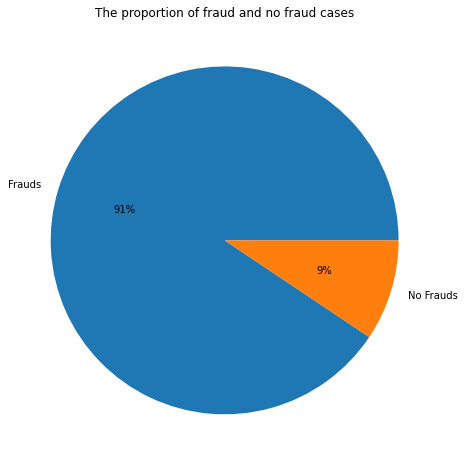

In [7]:
# Check the proportion of fraud and no frauds cases
print('No Frauds', round(fraud_df['class'].value_counts()[0]/len(fraud_df) * 100,2), '% of the dataset')
print('Frauds', round(fraud_df['class'].value_counts()[1]/len(fraud_df) * 100,2), '% of the dataset')

# Plot the proportion of fraud and no frauds cases 
a = fraud_df.groupby('class').agg({'user_id':'count'}).reset_index()
plt.figure(figsize=(16,8))
plt.pie(a['user_id'], labels = ['Frauds', 'No Frauds'], autopct='%.0f%%')
plt.title("The proportion of fraud and no fraud cases")
plt.show()

The data is heavily skewed between fraud and non-fraud cases (imbalanced dataset problem). We could handle this problem by deploying undersampling or oversampling techniques which will be presented below. Let see the distribution of other features 

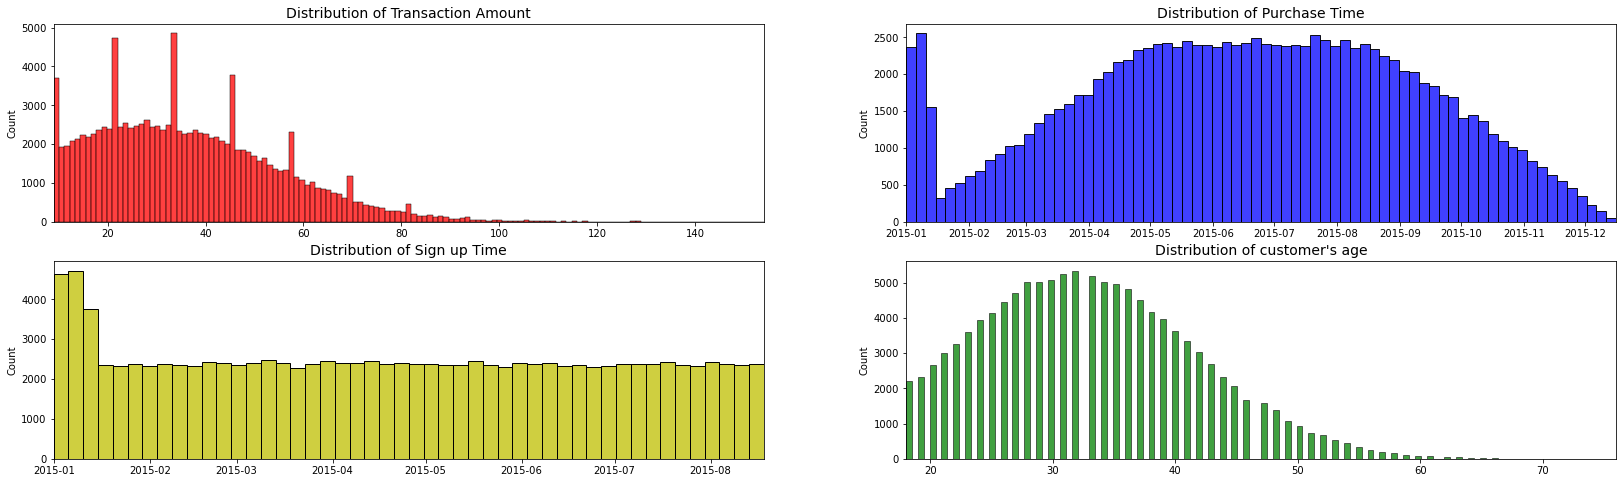

In [8]:
# For the continuous feature data we can plot the hisplot to see their distribution
fig, ax = plt.subplots(2, 2, figsize=(28,8))

amount_val = fraud_df['purchase_value'].values
purchase_time_val = fraud_df['purchase_time'].values
signup_time_val = fraud_df['signup_time'].values
age = fraud_df['age'].values

sns.histplot(amount_val, ax=ax[0,0], color='r')
ax[0,0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0,0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(purchase_time_val, ax=ax[0,1], color='b')
ax[0,1].set_title('Distribution of Purchase Time', fontsize=14)
ax[0,1].set_xlim([min(purchase_time_val), max(purchase_time_val)])

sns.histplot(signup_time_val, ax=ax[1,0], color='y')
ax[1,0].set_title('Distribution of Sign up Time', fontsize=14)
ax[1,0].set_xlim([min(signup_time_val), max(signup_time_val)])

sns.histplot(age, ax=ax[1,1], color='g')
ax[1,1].set_title("Distribution of customer's age", fontsize=14)
ax[1,1].set_xlim([min(age), max(age)])

plt.show()

Overall, these features do not suffered any heavy skweness. That is a good point for our data 

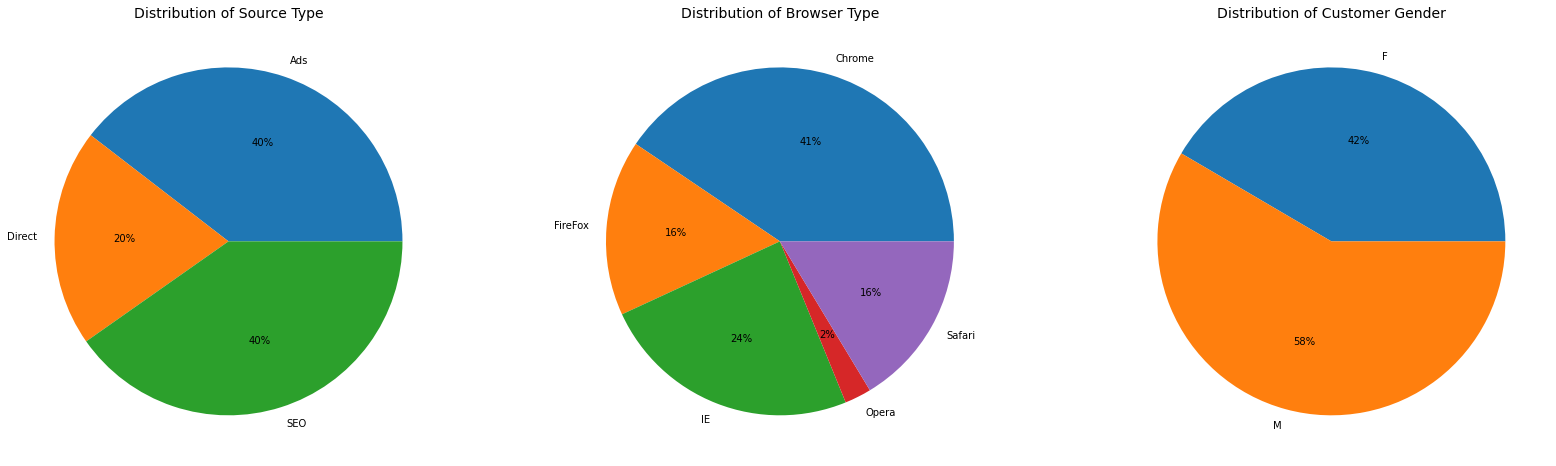

In [9]:
# Plot the proportion of these three category data (source, browser, and gender)
fig, ax = plt.subplots(1, 3, figsize=(28,8))

source = fraud_df.groupby('source').agg({'user_id':'count'}).reset_index()
browser = fraud_df.groupby('browser').agg({'user_id':'count'}).reset_index()
sex = fraud_df.groupby('sex').agg({'user_id':'count'}).reset_index()

ax[0].pie(source['user_id'],labels = source['source'], autopct='%.0f%%')
ax[0].set_title('Distribution of Source Type', fontsize=14)

ax[1].pie(browser['user_id'],labels = browser['browser'], autopct='%.0f%%')
ax[1].set_title('Distribution of Browser Type', fontsize=14)

ax[2].pie(sex['user_id'],labels = sex['sex'], autopct='%.0f%%')
ax[2].set_title('Distribution of Customer Gender', fontsize=14)

plt.show()

- Source: Most of customers come to Electronica from Ads and SEO which occupied 80% of the population 
- Browser: Chrome is the dominant brower used by customer. Surprisingly, IE stands up at the second
- Gender: The distribution of customer gender is quite equal which 58% of them are male

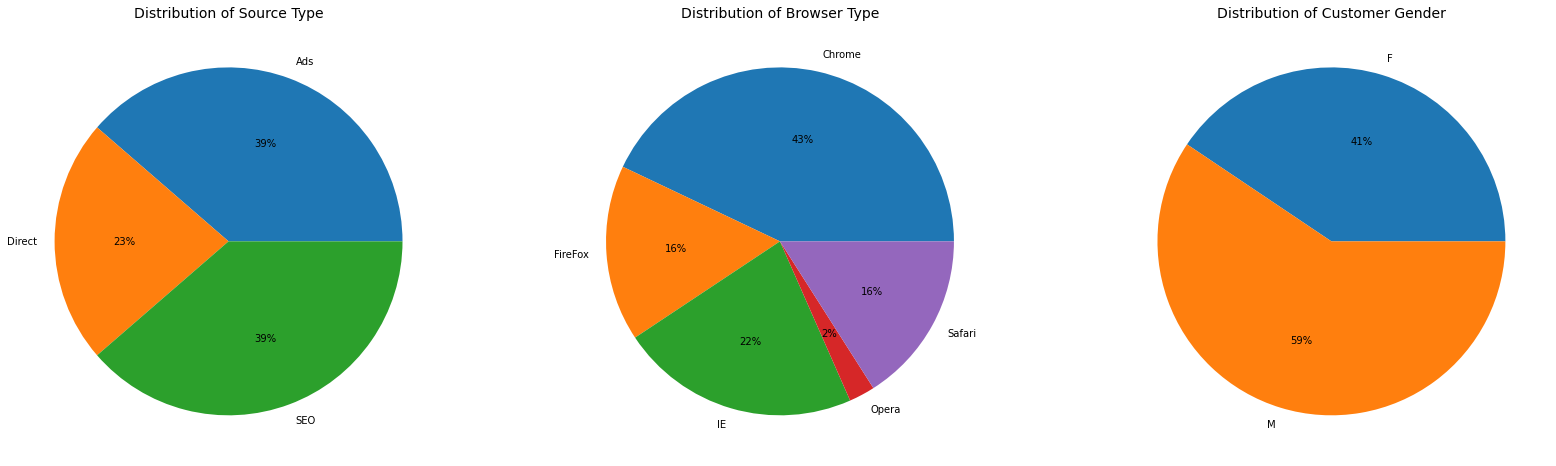

In [10]:
# Plot the proportion of these three category data (source, browser, and gender) in fraud cases 
# The goal is to see whether there is diffrence between the proportion of these features in fraud cases comprared to the whole population

fig, ax = plt.subplots(1, 3, figsize=(28,8))

a = fraud_df.loc[fraud_df['class'] == 1] # Choosing only fraud cases 

source = a.groupby('source').agg({'user_id':'count'}).reset_index()
browser = a.groupby('browser').agg({'user_id':'count'}).reset_index()
sex = a.groupby('sex').agg({'user_id':'count'}).reset_index()

ax[0].pie(source['user_id'],labels = source['source'], autopct='%.0f%%')
ax[0].set_title('Distribution of Source Type', fontsize=14)

ax[1].pie(browser['user_id'],labels = browser['browser'], autopct='%.0f%%')
ax[1].set_title('Distribution of Browser Type', fontsize=14)

ax[2].pie(sex['user_id'],labels = sex['sex'], autopct='%.0f%%')
ax[2].set_title('Distribution of Customer Gender', fontsize=14)

plt.show()

- Generally, there is no significant difference between these three category data in fraud cases compared to the whole population. Therefore, these three features might not usefull for our prediction model 

In [11]:
# Check the number of unique case of device ID
# Exclude the features to our model due to too many unique values which might cause overfiting problem to our model
print('The unique cases of device_id are', fraud_df['device_id'].nunique()) 

The unique cases of device_id are 110599


In [12]:
# The signup and purchase time might contain the valuable insight for detecting fraud
# Therefore, I would like to "zoom" these features into closer scale 

fraud_df['month_signup'] = pd.DatetimeIndex(fraud_df['signup_time']).month    # The month of signup time
fraud_df['month_purchase'] = pd.DatetimeIndex(fraud_df['purchase_time']).month # The month of purchase time
fraud_df['day_signup'] = fraud_df['signup_time'].dt.day_name()                 # The day in week signup time
fraud_df['day_purchase'] = fraud_df['purchase_time'].dt.day_name()             # The day in week signup time

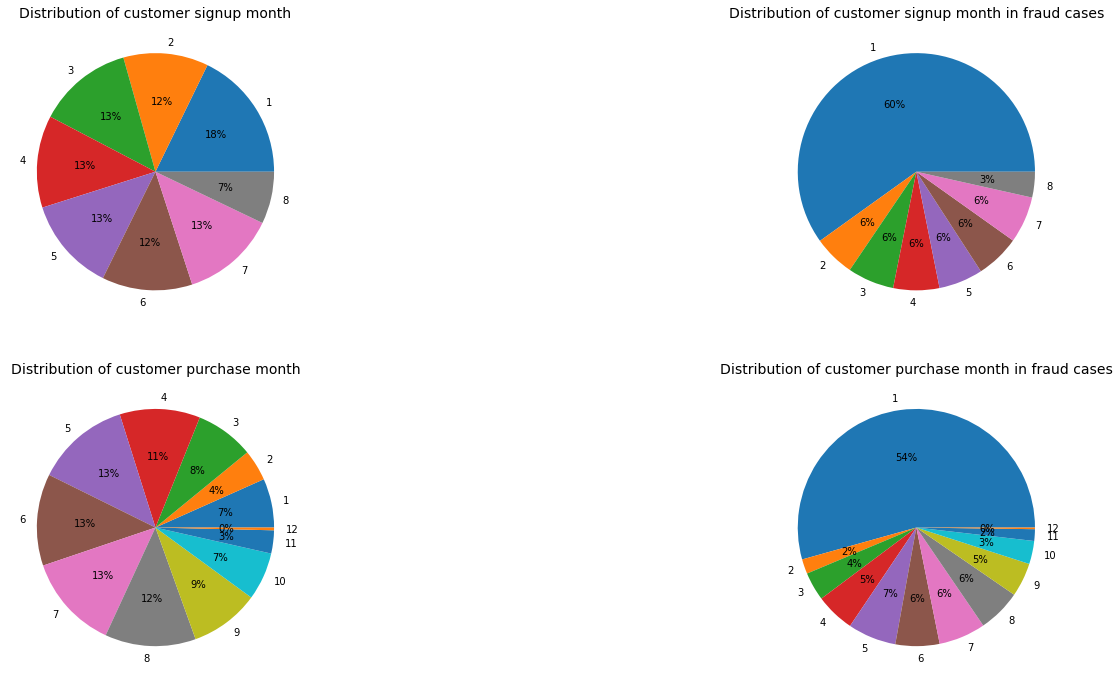

In [13]:
# Plot the distribution of different months of signup time and purchase time in whole populationa and fraud cases
fig, ax = plt.subplots(2, 2, figsize=(25,12))

a = fraud_df.groupby('month_signup').agg({'user_id':'count'}).reset_index()
ax[0,0].pie(a['user_id'], labels = a['month_signup'], autopct='%.0f%%')
ax[0,0].set_title('Distribution of customer signup month', fontsize=14)

a = fraud_df.loc[fraud_df['class'] == 1]
b = a.groupby('month_signup').agg({'user_id':'count'}).reset_index()
ax[0,1].pie(b['user_id'], labels = b['month_signup'], autopct='%.0f%%')
ax[0,1].set_title('Distribution of customer signup month in fraud cases', fontsize=14)

a = fraud_df.groupby('month_purchase').agg({'user_id':'count'}).reset_index()
ax[1,0].pie(a['user_id'], labels = a['month_purchase'], autopct='%.0f%%')
ax[1,0].set_title('Distribution of customer purchase month', fontsize=14)

a = fraud_df.loc[fraud_df['class'] == 1]
b = a.groupby('month_purchase').agg({'user_id':'count'}).reset_index()
ax[1,1].pie(b['user_id'], labels = b['month_purchase'], autopct='%.0f%%')
ax[1,1].set_title('Distribution of customer purchase month in fraud cases', fontsize=14)

plt.show()

- The distribution of each month of signup and purchase time in whole population is quite equal while interestingly, most of fraud cases happened in January in both sigup and purchase time => It's maybe because the time elapse between signup and purchase time is very short in fraud cases. We will examine closer below 

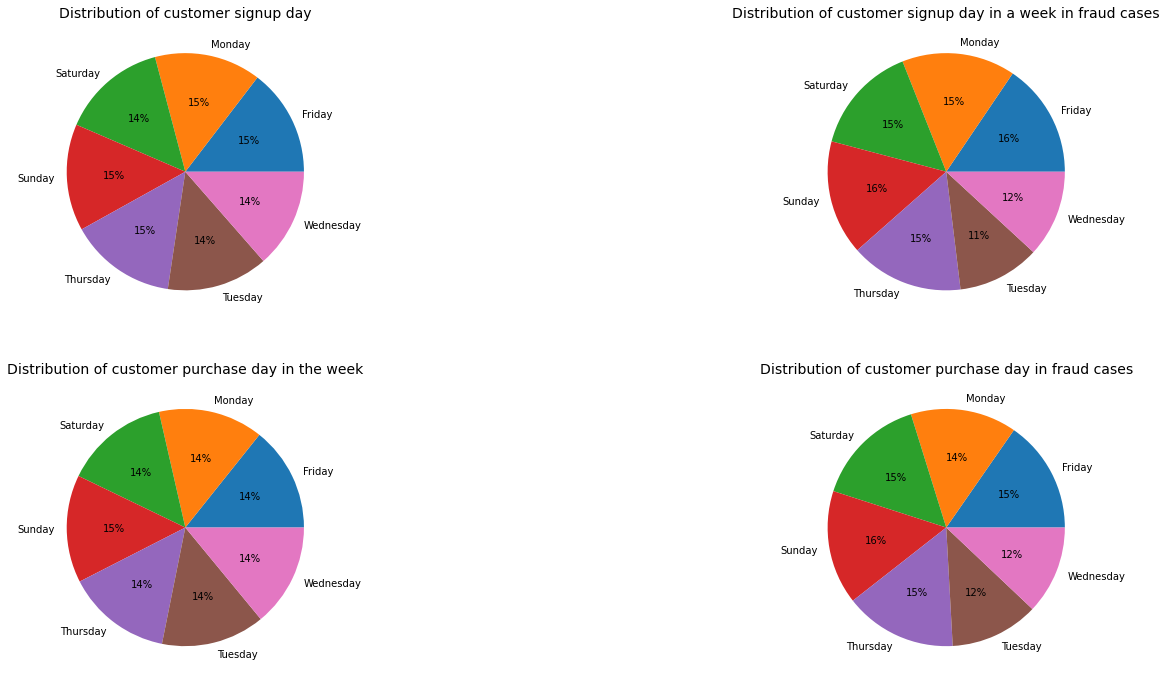

In [14]:
# Plot the distribution of different day in week of signup time and purchase time in whole populationa and fraud cases

fig, ax = plt.subplots(2, 2, figsize=(25,12))

a = fraud_df.groupby('day_signup').agg({'user_id':'count'}).reset_index()
ax[0,0].pie(a['user_id'], labels = a['day_signup'], autopct='%.0f%%')
ax[0,0].set_title('Distribution of customer signup day', fontsize=14)

a = fraud_df.loc[fraud_df['class'] == 1]
b = a.groupby('day_signup').agg({'user_id':'count'}).reset_index()
ax[0,1].pie(b['user_id'], labels = b['day_signup'], autopct='%.0f%%')
ax[0,1].set_title('Distribution of customer signup day in a week in fraud cases', fontsize=14)

a = fraud_df.groupby('day_purchase').agg({'user_id':'count'}).reset_index()
ax[1,0].pie(a['user_id'], labels = a['day_purchase'], autopct='%.0f%%')
ax[1,0].set_title('Distribution of customer purchase day in the week', fontsize=14)

a = fraud_df.loc[fraud_df['class'] == 1]
b = a.groupby('day_purchase').agg({'user_id':'count'}).reset_index()
ax[1,1].pie(b['user_id'], labels = b['day_purchase'], autopct='%.0f%%')
ax[1,1].set_title('Distribution of customer purchase day in fraud cases', fontsize=14)

plt.show()

- Unfortunately, there is no different between day in week between whole population and fraud cases 

In [15]:
# Create a column which indicates the time elapse between signup time and purchase time
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.days # The measurement unit is day

count    120000.000000
mean         56.622417
std          36.160088
min           0.000000
25%          25.000000
50%          56.000000
75%          88.000000
max         119.000000
Name: time_diff, dtype: float64
count    11265.000000
mean        27.981181
std         38.215383
min          0.000000
25%          0.000000
50%          0.000000
75%         56.000000
max        119.000000
Name: time_diff, dtype: float64


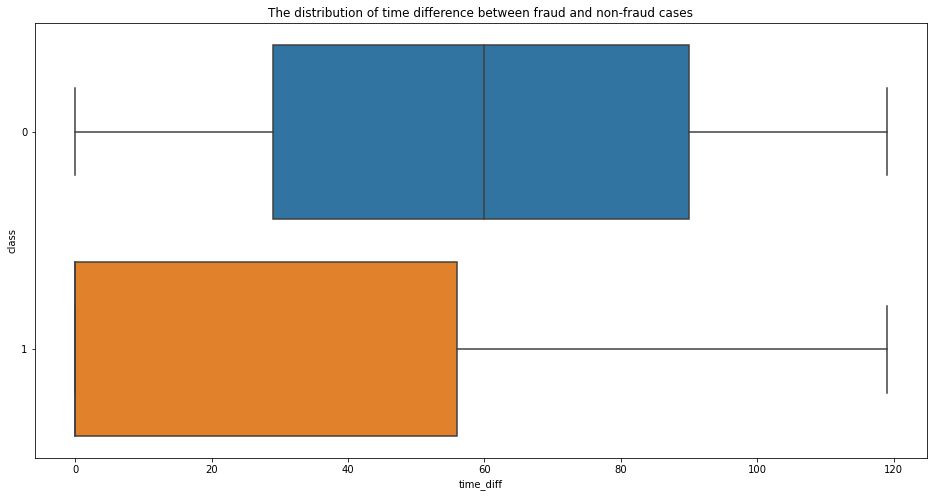

In [16]:
print(fraud_df['time_diff'].describe())
a = fraud_df.loc[fraud_df['class'] == 1]
print(a['time_diff'].describe())

plt.figure(figsize=(16,8))
sns.boxplot(data = fraud_df, x = 'time_diff', y='class', orient='h')
plt.title("The distribution of time difference between fraud and non-fraud cases")
plt.show()

- It is a huge different between fraud cases and whole population in terms of "time_diff". More than 50% of fraud cases when the scammer creates the account and purchase in the same date => We will "zoom" closer into "time_diff" to see whether it happends within minutes or seconds

count    1.200000e+05
mean     4.933112e+06
std      3.127784e+06
min      0.000000e+00
25%      2.188140e+06
50%      4.924380e+06
75%      7.648215e+06
max      1.036794e+07
Name: second_diff, dtype: float64
count    1.126500e+04
mean     2.437529e+06
std      3.318875e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.849260e+06
max      1.036398e+07
Name: second_diff, dtype: float64


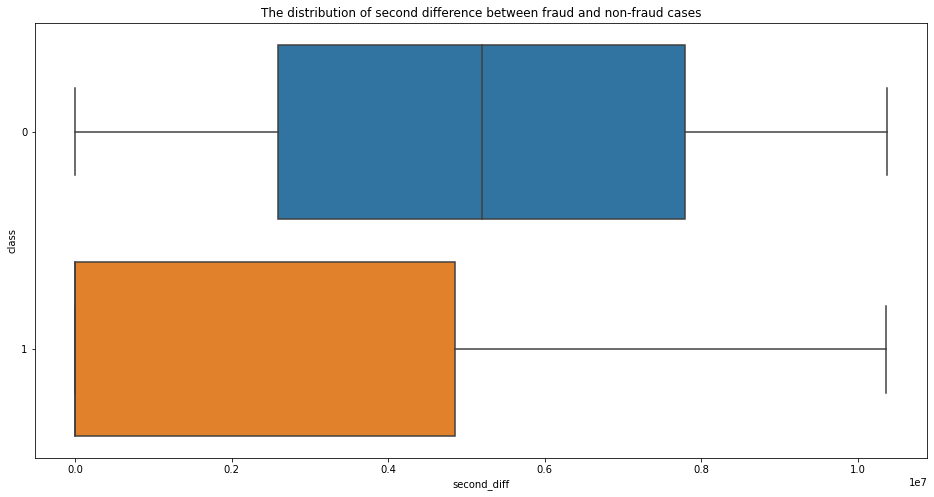

In [17]:
# By observation, it looks like the signup and purchase time just record to minute scale. However, it doesn't hurt when we calculate the second scale to make sure 
fraud_df['second_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() # Measurement unit is second

print(fraud_df['second_diff'].describe())
a = fraud_df.loc[fraud_df['class'] == 1]
print(a['second_diff'].describe())

plt.figure(figsize=(16,8))
sns.boxplot(data = fraud_df, x = 'second_diff', y='class', orient='h')
plt.title("The distribution of second difference between fraud and non-fraud cases")

plt.show()

- Again, more than 50% fraud cases when the scammer execute opening an account and purchasing item within a minute (Maybe they use "clone" application sofware to execute this fast). And the "second_diff" is very short compared to the whole population => This feature is very usefull for our model to detect the fraud

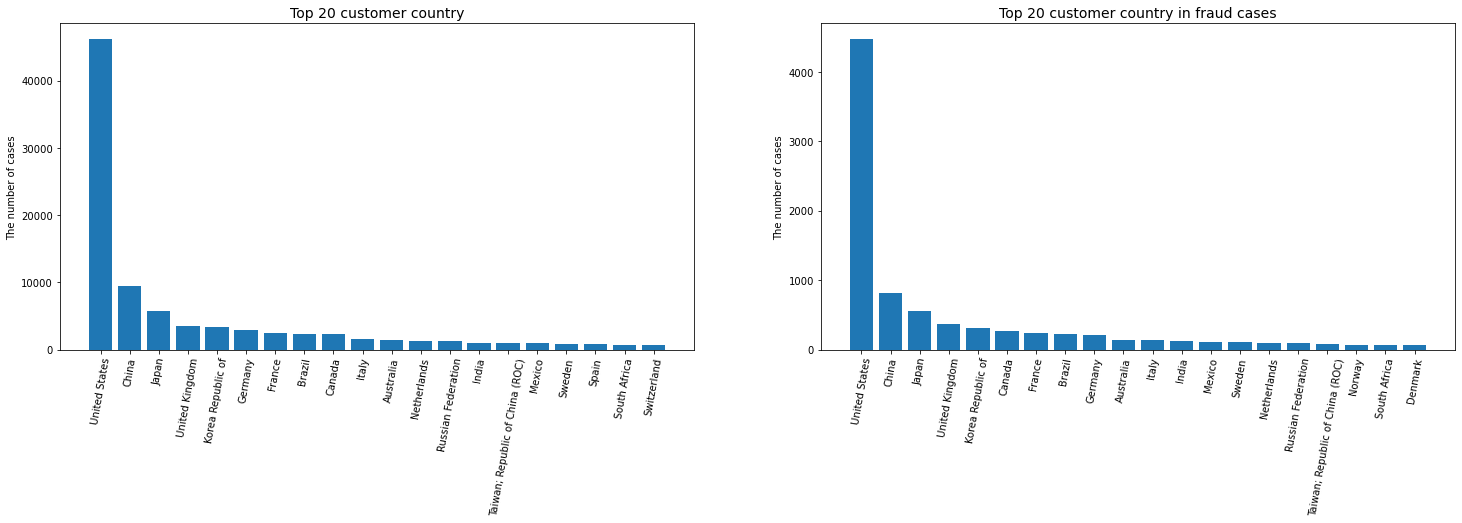

In [18]:
#Plot the top 20 countries our customer locate based on IP address
fig, ax = plt.subplots(1, 2, figsize=(25,6))

a = fraud_df.groupby('country').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
a = a[:20]
ax[0].bar(a['country'], a['user_id'])
ax[0].set_ylabel('The number of cases')
ax[0].set_title('Top 20 customer country', fontsize=14)
ax[0].tick_params(axis='x', labelrotation=80)

a = fraud_df.loc[fraud_df['class'] == 1]
b = a.groupby('country').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
b = b[:20]
ax[1].bar(b['country'], b['user_id'])
ax[1].set_ylabel('The number of cases')
ax[1].set_title('Top 20 customer country in fraud cases', fontsize=14)
plt.xticks(rotation=80)

plt.show()

- Overall, there is no different in the top 20 customer countries between whole population and fraud cases. The order even keep the same in top five. 

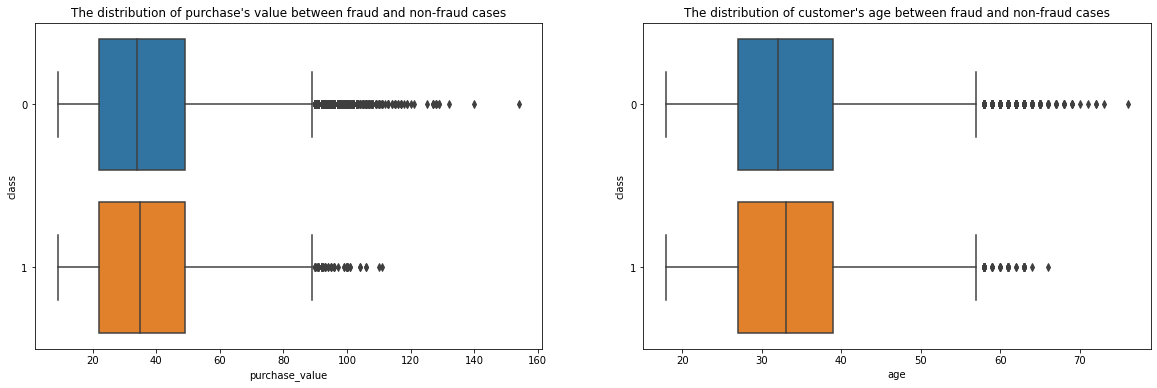

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# The distribution of purchase's value between fraud and non-fraud cases
sns.boxplot(data = fraud_df, x = 'purchase_value', y='class', orient='h', ax=ax[0])
ax[0].set_title("The distribution of purchase's value between fraud and non-fraud cases")

# The distribution of customer's age between fraud and non-fraud cases
sns.boxplot(data = fraud_df, x = 'age', y='class', orient='h', ax=ax[1])
ax[1].set_title("The distribution of customer's age between fraud and non-fraud cases")

plt.show()

As we can see there are no difference between purchase's value, customer's age between fraud and non-fraud cases 

## Feature Engineering

Based on the EDA results above, and optimizing the computational cost, I exclude all these features which have no differences between fraud cases and whole population <br>
Just keeping only these features which can help our model detect fraud cases. There are three features I will use to build the prediction model: <br>
- "Second_diff": The time elapse between signup time and purchase time measured by second 
- "Month_signup": The month of the customer openning an account
- "Month_purchase": The month of the customer buying an item 

In [20]:
feature_df = fraud_df[['second_diff','month_signup','month_purchase','class']]
feature_df 

,second_diff,month_signup,month_purchase,class
0,4959660.0,7,9,0
1,6798240.0,1,4,0
2,2201340.0,3,4,0
3,161580.0,1,1,0
4,5159700.0,2,4,0
...,...,...,...,...
119995,4273560.0,2,4,0
119996,2034960.0,8,8,0
119997,3424800.0,7,9,0
119998,6982800.0,4,6,0


Before proceeding with the Random UnderSampling or OverSampling techniques I will separate the orginal dataframe. <br> 
Because we want to test our models on the original testing set not on the testing set created by either of these techniques. <br> 
The main goal is to fit and tuningthe model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [21]:
X = feature_df.drop('class', axis=1)
y = feature_df['class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) #StratifiendKFold preserv the percentage of sample for each class

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

std_scaler = StandardScaler()

features = ['second_diff', 'month_signup','month_purchase']

original_Xtrain[features] = std_scaler.fit_transform(original_Xtrain[features])
original_Xtest[features] = std_scaler.fit_transform(original_Xtest[features])    

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 23770  23773  23797 ... 119997 119998 119999] Test: [    0     1     2 ... 24017 24018 24020]
Train: [     0      1      2 ... 119997 119998 119999] Test: [23770 23773 23797 ... 48003 48004 48006]
Train: [     0      1      2 ... 119997 119998 119999] Test: [47930 47940 47946 ... 72179 72188 72223]
Train: [     0      1      2 ... 119997 119998 119999] Test: [71969 71970 71971 ... 95997 95998 96002]
Train: [    0     1     2 ... 95997 95998 96002] Test: [ 95999  96000  96001 ... 119997 119998 119999]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.906125 0.093875]
[0.906125 0.093875]


## Building Machine Learning Models Using Undersampling and Oversampling techniques

### Random Undersampling Technique

In [22]:
# Shuffle the data before creating the subsamples
num = feature_df.loc[feature_df['class'] == 1].shape[0] # The number of fraud cases

df = feature_df.sample(frac=1)

fraud_df = df.loc[df['class'] == 1]

non_fraud_df = df.loc[df['class'] == 0][:num] # Get the non-fraud cases which have same size to the number of fraud cases

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# Creating the sub sample which equally distributed both classes
new_df.head()

,second_diff,month_signup,month_purchase,class
109444,7796940.0,8,11,0
48724,0.0,1,1,1
73823,0.0,1,1,1
8115,8199840.0,6,9,1
50135,8654100.0,3,6,0


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: class, dtype: float64


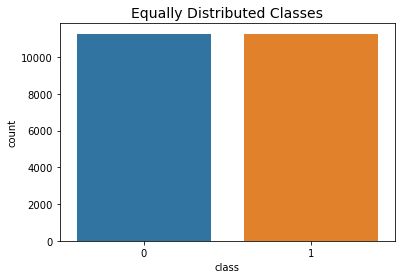

In [23]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['class'].value_counts()/len(new_df))

sns.countplot('class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [24]:
# Undersampling before cross validating 
X_under = new_df.drop('class', axis=1)
y_under = new_df['class']

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)


# Scale data. For other ensemble learning ML models such as XGB or LGBM, it's not neccessary to scale the data. However, we deploy Logistic, KNN which need to scale data before fit in
X_train[features] = std_scaler.fit_transform(X_train[features])
X_test[features] = std_scaler.fit_transform(X_test[features])

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBoost Classifier": xgb.XGBClassifier(eval_metric='mlogloss'),
    "LightBGM": lightgbm.LGBMClassifier()
}

from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 69.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 72.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 69.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 69.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 76.0 % accuracy score
Classifiers:  LGBMClassifier Has a training score of 76.0 % accuracy score


With the initial runing, the LGBM Classifier and XGB Classifier reach the best performance compared to the other ML model. However, because of time contrainst, I will chose LGBM model which is significantly faster than XGB Classifier

### Tuning and Optimizing ML Model 

In [25]:
# Grid Search CV is deployed to search the best params for LGBM. One downside of the technique is computation cost. 

param_dist = {'n_estimators':[100,300,500],
              'learning_rate': [0.01,0.05, 0.1],
              'max_depth': [6, 9, 12], 
              'reg_lambda': [0.2,0.4,0.6]}

light = lightgbm.LGBMClassifier()

grid_light = GridSearchCV(light, param_dist)
grid_light.fit(X_train, y_train)

# Light best estimator
light_best = grid_light.best_estimator_

In [26]:
score = cross_val_score(light_best, X_train, y_train, cv=5)
print('LightBGM Classifier Cross Validation Score', round(score.mean() * 100, 2).astype(str) + '%')

LightBGM Classifier Cross Validation Score 76.79%


The accuracy increase slightly 1% after tunning, reaching roughly 77%

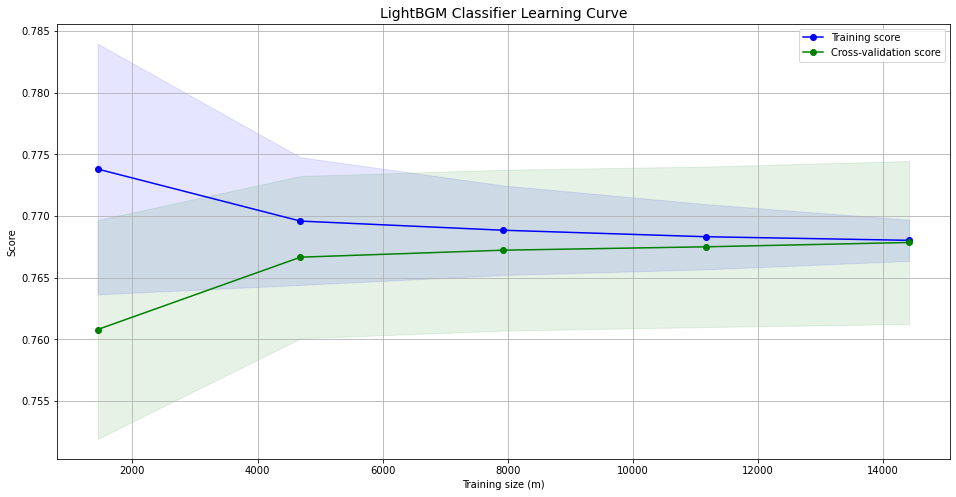

In [27]:
#Plot to see the convergence of model performance after each training size
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(light_best, X_train, y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

f, ax1 = plt.subplots(1,1, figsize=(16,8), sharey=True)
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='b')
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax1.set_title("LightBGM Classifier Learning Curve", fontsize=14)
ax1.set_xlabel('Training size (m)')
ax1.set_ylabel('Score')
ax1.grid(True)
ax1.legend(loc="best")

plt.show()

We can see that the model converges nicely. It suggests that there is little room to increase the accuracy just by tuning hyperparameters 

In [28]:
# This step is deploying random undersampling technique in our original dataset we split before and finally, our model will try to predict the original test set. 
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels I won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(X.values, y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating in the original train test to find the best params 
for train, test in sss.split(original_Xtrain, original_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), grid_light)  #Undersampling happens during Cross Validation not before
    undersample_model = undersample_pipeline.fit(original_Xtrain[train], original_ytrain[train])
    undersample_best_est = grid_light.best_estimator_
    undersample_prediction = undersample_best_est.predict(original_Xtrain[test])
    
    # Metrics indicate how well our model performs in training dataset
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

NearMiss Label Distribution: Counter({0: 11265, 1: 11265})


In [29]:
print('---' * 45)
print('')
print("The metrics indidate how well our model performs in original training dataset")
print("accuracy: {}".format(np.mean(undersample_accuracy)))
print("precision: {}".format(np.mean(undersample_precision)))
print("recall: {}".format(np.mean(undersample_recall)))
print("f1: {}".format(np.mean(undersample_f1)))
print("AUC score: {}".format(np.mean(undersample_auc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

The metrics indidate how well our model performs in original training dataset
accuracy: 0.462125
precision: 0.12642949885079455
recall: 0.8001580791171208
f1: 0.2183424948116301
AUC score: 0.6136315362090216
---------------------------------------------------------------------------------------------------------------------------------------


In [30]:
# Testing the model performance in original testing dataset 
labels = ['No Fraud', 'Fraud']

undersample_prediction = light_best.predict(original_Xtest) #Prediction the original testing dataset

print(classification_report(original_ytest, undersample_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       0.95      0.86      0.91     21747
       Fraud       0.31      0.59      0.41      2253

    accuracy                           0.84     24000
   macro avg       0.63      0.73      0.66     24000
weighted avg       0.89      0.84      0.86     24000



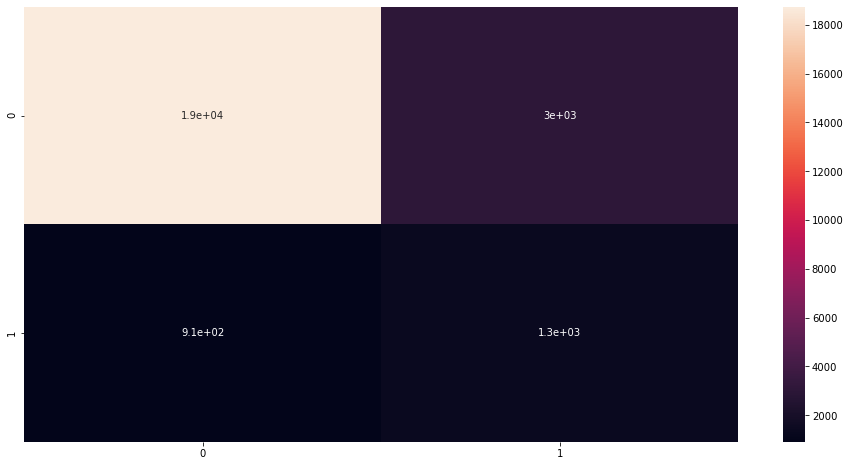

In [31]:
cf_matrix = confusion_matrix(original_ytest, undersample_prediction)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [32]:
average_precision = average_precision_score(original_ytest, undersample_prediction)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.22


AUC of ROC Curve: 0.7281073465786211


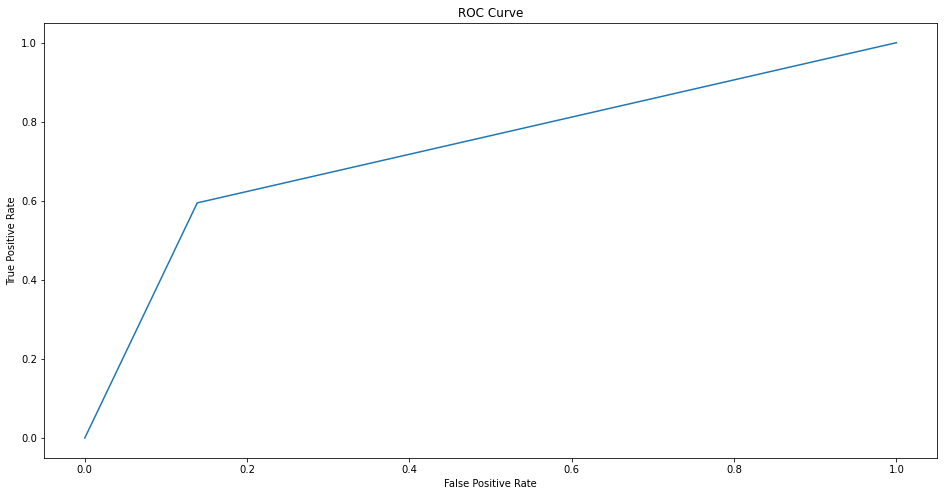

In [33]:
fpr, tpr, thresholds = roc_curve(original_ytest, undersample_prediction)
roc_auc = roc_auc_score(original_ytest, undersample_prediction)
print("AUC of ROC Curve:", roc_auc)

plt.figure(figsize=(16,8))
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

- Unfortunately, the model performs not good in this case which indicates that the random undersampling might not a best choice for this particular proplem. 
- The false positive cases and false negative cases are still high. 
- I will test the oversampling technique (SMOTE) below

### Oversampling Technique

For Oversampling technique, I will use the Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class (fraud cases)

In [34]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

param_dist = {'n_estimators':[100,300,500],
              'learning_rate': [0.01,0.05, 0.1],
              'max_depth': [6, 9, 12], 
              'reg_lambda': [0.2,0.4,0.6]}

# For time contrainst and optimizing computation cost, I will use RandomizedSearch to find best params
light_rd = RandomizedSearchCV(light, 
                         param_distributions = param_dist,
                         n_iter = 10)

# Again, training and finding best params in original training dataset 
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), light_rd) #SMOTE happens during Cross Validation not before
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = light_rd.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("The metrics indidate how well our model performs in original training dataset")
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 96000 | Length of y (train): 96000
Length of X (test): 24000 | Length of y (test): 24000
---------------------------------------------------------------------------------------------------------------------------------------

The metrics indidate how well our model performs in original training dataset
accuracy: 0.91540625
precision: 0.549507712365477
recall: 0.5555936800362942
f1: 0.5523489165366047
---------------------------------------------------------------------------------------------------------------------------------------


In [35]:
# Testing the model performance in original testing dataset 
labels = ['No Fraud', 'Fraud']

smote_prediction = best_est.predict(original_Xtest) # Prediction the original testing dataset

print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       0.95      0.95      0.95     21747
       Fraud       0.53      0.55      0.54      2253

    accuracy                           0.91     24000
   macro avg       0.74      0.75      0.75     24000
weighted avg       0.91      0.91      0.91     24000



<AxesSubplot:>

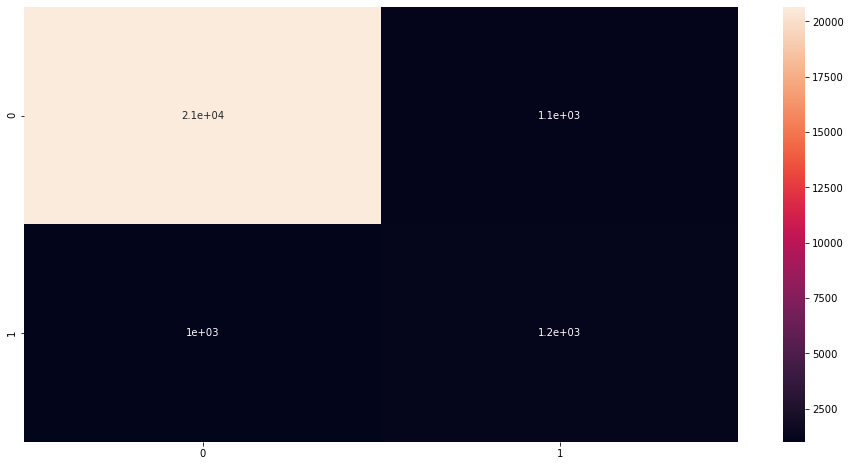

In [36]:
cf_matrix = confusion_matrix(original_ytest, smote_prediction)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=True)

In [37]:
average_precision = average_precision_score(original_ytest, smote_prediction)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.33


AUC of ROC Curve: 0.7501427106556535


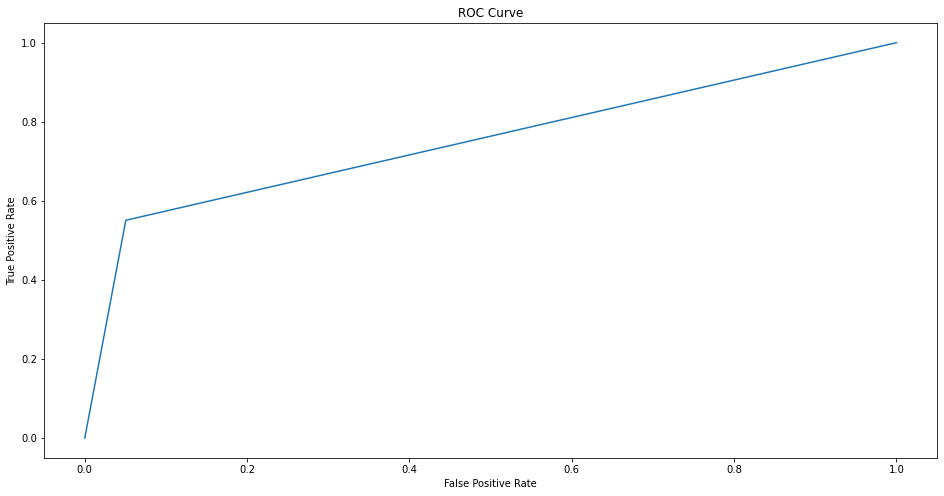

In [38]:
fpr, tpr, thresholds = roc_curve(original_ytest, smote_prediction)
roc_auc = roc_auc_score(original_ytest, smote_prediction)
print("AUC of ROC Curve:", roc_auc)

plt.figure(figsize=(16,8))
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

- The results is better compared to undersampling technique which lower false positive cases and lower false negative cases
- The AUC score reaches 0.755


## Building Deep Learning Model Using Undersampling and Oversampling techniques 

In [39]:
# create ANN model

model = keras.Sequential(
    [
        layers.Dense(3, activation='relu'),
        layers.Dense(50,  activation = 'relu', name='hidden_layer1'),
        layers.Dense(40, activation='relu', name='hidden_layer2'),
        layers.Dense(20, activation='relu', name='hidden_layer3'),
        layers.Dense(1, activation='sigmoid', name='output_layer')
    ]
)

model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Undersampling

In [40]:
model.fit(X_train, y_train, validation_split=0.2, batch_size=300, epochs=500, shuffle=True, verbose=0)
undersample_predictions = model.predict_classes(original_Xtest, batch_size=300, verbose=0)

In [41]:
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, undersample_predictions, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       0.95      0.94      0.94     21747
       Fraud       0.47      0.56      0.51      2253

    accuracy                           0.90     24000
   macro avg       0.71      0.75      0.73     24000
weighted avg       0.91      0.90      0.90     24000



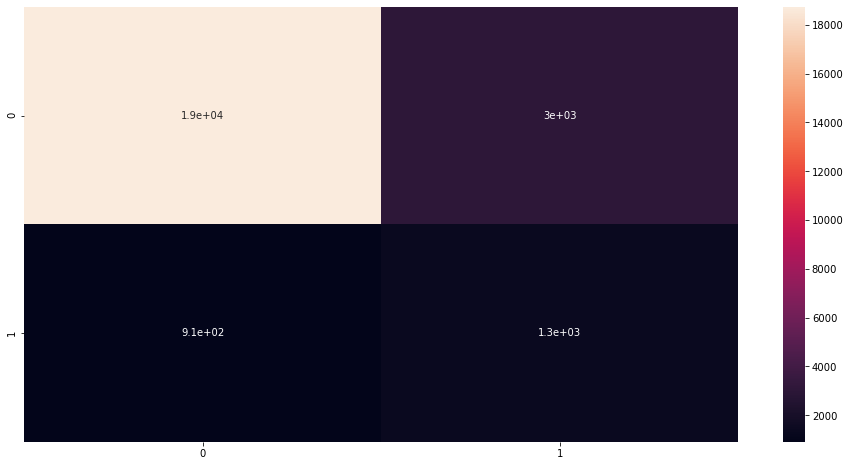

In [42]:
cf_matrix = confusion_matrix(original_ytest, undersample_prediction)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=True)
plt.show()

### Oversampling

In [43]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [44]:
model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=500, shuffle=True, verbose=0)
oversample_fraud_predictions = model.predict_classes(original_Xtest, batch_size=300, verbose=0)

In [45]:
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, oversample_fraud_predictions, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       0.95      1.00      0.98     21747
       Fraud       1.00      0.53      0.69      2253

    accuracy                           0.96     24000
   macro avg       0.98      0.77      0.84     24000
weighted avg       0.96      0.96      0.95     24000



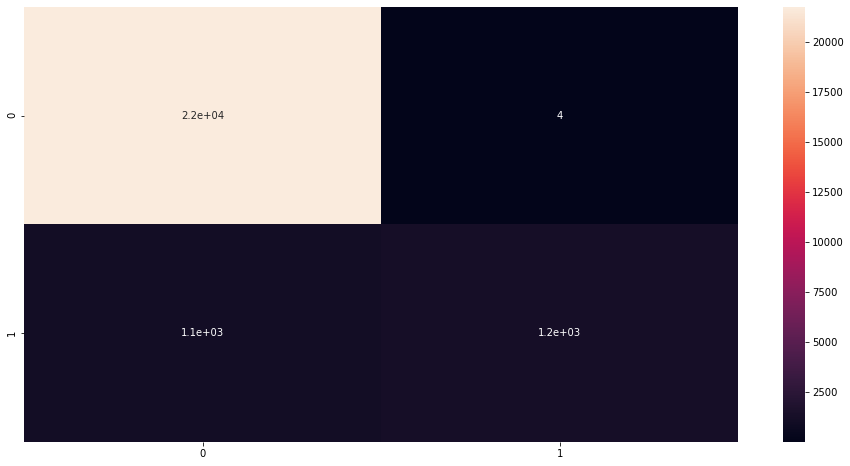

In [46]:
cf_matrix = confusion_matrix(original_ytest, oversample_fraud_predictions)
plt.figure(figsize=(16,8))
sns.heatmap(cf_matrix, annot=True)
plt.show()

- With all these metric results above, we can see that the Deep Learning (ANN) model with oversampling technique has the best performance. 
- For detecting the fraud cases, ANN and LGBM perform well equally with recall reaches above 53% 
- However, for detecting non-fraud cases, ANN perform more accurately compared to LGBM with just a few cases false positive. 

With one incorrectly a real transaction as fraudulent, it inconveniences the Electronica customers whose valid transactions are flagged—a cost client values at 8 dollars. <br>
Therefore, ANN model is more economical. <br>

With this reason, I choose ANN model as the final model.


## Conclusion and Recommendation

The notebook tries to build the classification prediction model detecting fraud case. With limited features and the data is suffered the imbalanced dataset problem, I present two technique to handle the problem which are:
- Random Undersampling
- Oversampling (SMOTE)

Several different ML models also tested such as logistic regression, KNN, RandomForest, Decision Tree, XGBoost, LBGM, and deep learning model (ANN) also tested. <br>

Because of time contrainst and computational cost, other models are not investigated deeper. <br>

LGBM and ANN model with oversampling technique are the best performances. However, the ANN model will be chosen because of the more accuracy in detecting non-fraud cases <br>

#### Recommendation 
Due to the time contrainst and computational cost, there are three points we can investigate more in the next phase to reach a better performance:

- Testing and investigating more other ML models 
- Investigating deeper on tunning parameter in ANN model 
- Collecting more relevant features data such as customer's payment method information, type of bought items etc

